# Process Mining Group 9

## Preprocessing

In [1]:
import pandas as pd
import pm4py

path_to_file = "Dataset/Production_Analysis/Production_Data.csv"
# Load and format the event log
log = pd.read_csv(path_to_file)

# Replace Na/Y in column names with binary values
log['Rework'] = log['Rework'].fillna(0)  # Replace None with 0
log['Rework'] = log['Rework'].replace('Y', 1)  # Replace 'Y' with 1

# Drop columns that are not needed
log = log.drop('Span', axis=1)

# Check for duplicate columns, and remove them
log = log.loc[:, ~log.columns.duplicated()]

C:\Users\thier\AppData\Local\Temp\ipykernel_11444\3686824453.py:10: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  log['Rework'] = log['Rework'].replace('Y', 1)  # Replace 'Y' with 1


In [2]:
# Rename columns to match PM4Py conventions
log['caseID'] = log['Case ID']
log = log.rename(columns={
    'Case ID': 'case:concept:name',     # Case identifier
    'Start Timestamp': 'time:timestamp', # Start timestamp
    'Activity': 'concept:name',         # Activity
    'Complete Timestamp': 'complete:timestamp',
    'Resource': 'resource',             # Resource (machine/operator)
    'Qty Completed': 'qty:completed',   # Quantity completed
    'Qty Rejected': 'qty:rejected',     # Quantity rejected
    'Qty for MRB': 'qty:for_mrb',       # Material Review Board quantities
    'Rework': 'rework_flag',            # Rework flag
    'Work Order  Qty': 'case:work_order_qty', # Work order quantity
    'Part Desc.': 'case:part_desc'         # Part description
})

In [3]:
# Convert timestamps to datetime format
log['time:timestamp'] = pd.to_datetime(log['time:timestamp'])
log['complete:timestamp'] = pd.to_datetime(log['complete:timestamp'])

# Calculate additional features
log['case_start_time'] = log.groupby('case:concept:name')['time:timestamp'].transform('min')
log['time_since_case_start'] = (log['time:timestamp'] - log['case_start_time']).dt.total_seconds()

log['Event Completion Time (minutes)'] = (log['complete:timestamp'] - log['time:timestamp']).dt.total_seconds() / 60
log['case:Total Duration'] = log.groupby('case:concept:name')['Event Completion Time (minutes)'].transform('sum')
log['case_completion_time'] = log.groupby('case:concept:name').apply(
        lambda group: group['case:Total Duration'] - group['Event Completion Time (minutes)'].cumsum().shift(fill_value=0)
    ).reset_index(drop=True)

log.to_csv("CheckLog.csv", index=False)
df_production = log


C:\Users\thier\AppData\Local\Temp\ipykernel_11444\1095258949.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  log['case_completion_time'] = log.groupby('case:concept:name').apply(


## Intra-case: Baseline

### Create event log

In [4]:
# Define feature extraction parameters
case_id_key = 'case:concept:name'
target_key = 'case_completion_time' # this is an event variable. it is calculated dynamically, right?
numerical_vars = ['qty:completed', 'qty:rejected', 'qty:for_mrb', 'rework_flag']
numerical_case_vars = ['case:work_order_qty']
categorical_vars = ['concept:name', 'resource', 'Worker ID', 'Report Type', 'case:part_desc'  ]
timestamp_var = 'time:timestamp'
complete_timestamp_var = 'complete:timestamp'

In [5]:
from tqdm import tqdm
# Format the DataFrame for PM4Py
log = pm4py.format_dataframe(log, case_id='case:concept:name', activity_key='concept:name', timestamp_key='time:timestamp')

# Convert to EventLog for further analysis
event_log = pm4py.convert_to_event_log(log)
#event_log = pm4py.get_prefixes_from_log(event_log, 1)

# function for extracting prefix features with tqdm progress bar
from tqdm import tqdm

def extract_prefix_features_with_timestamps(
    event_log,
    case_id_key,
    target_key,
    numerical_vars,
    categorical_vars,
    case_vars,
    timestamp_var,
    complete_timestamp_var,
    max_length,
    extra_column=None,
):
    """
    Extract prefixes for all cases, calculate start and end times for each prefix,
    and pad the remaining prefixes with default values.
    """
    prefixes_with_features = []

    # Process prefixes of increasing length
    for length in tqdm(range(1, max_length + 1), desc="Processing prefix lengths", unit="prefix length"):
        # Extract prefixes
        prefix_log = pm4py.get_prefixes_from_log(event_log, length=length)
        prefix_df = pm4py.convert_to_dataframe(prefix_log)

        # Handle cases with fewer events than the current prefix length
        case_event_counts = prefix_df.groupby(case_id_key).size()  # Count events per case
        valid_cases = case_event_counts[case_event_counts >= length].index  # Filter cases with enough events

        # Filter the prefix dataframe to include only valid cases for this length
        prefix_df = prefix_df[prefix_df[case_id_key].isin(valid_cases)]

        # If no valid cases exist for the current prefix length, skip this iteration
        if prefix_df.empty:
            continue

        # Generate prefix IDs
        prefix_df["prefix_id"] = prefix_df[case_id_key] + "_prefix_" + str(length)

        # Add a flag for the last event in the prefix
        prefix_df["is_last_event"] = prefix_df.groupby("prefix_id")[timestamp_var].transform("max") == prefix_df[timestamp_var]

        # Aggregate numerical variables
        for col in numerical_vars:
            if col in prefix_df.columns:
                prefix_df[col] = prefix_df.groupby("prefix_id")[col].transform("sum")

        # Aggregate categorical variables
        for col in categorical_vars:
            if col in prefix_df.columns:
                prefix_df[col] = prefix_df.groupby("prefix_id")[col].transform(
                    lambda x: x.mode()[0] if not x.mode().empty else None
                )

        # Add case-level variables
        for case_var in case_vars:
            if case_var in prefix_df.columns:
                prefix_df[case_var] = prefix_df.groupby(case_id_key)[case_var].transform("first")

        # Calculate `case_completion_time` for each prefix
        prefix_df["case_completion_time"] = prefix_df.groupby("prefix_id")[target_key].transform("last")

        # Extract start and end times for each prefix
        prefix_df["start_time"] = prefix_df.groupby(case_id_key)[timestamp_var].transform("first")  # First event of the case
        prefix_df["end_time"] = prefix_df.groupby("prefix_id")[complete_timestamp_var].transform("max")  # Current prefix's end time

        # Keep selected columns
        selected_cols = [
            case_id_key, "prefix_id", "case_completion_time", "start_time", "end_time", timestamp_var,
            complete_timestamp_var, "is_last_event"
        ] + numerical_vars + categorical_vars + case_vars

        if extra_column:
            selected_cols.append(extra_column)

        prefixes_with_features.append(prefix_df[selected_cols].drop_duplicates(subset=["prefix_id"]))

    # Combine all prefixes
    combined_df = pd.concat(prefixes_with_features, ignore_index=True)

    # Add padding for missing prefixes
    padded_features = []
    for case_id, case_group in combined_df.groupby(case_id_key):
        # Detect the last meaningful prefix based on case completion time
        case_group["is_last_prefix"] = case_group["case_completion_time"].diff().fillna(0) != 0

        if case_group["is_last_prefix"].any():
            last_valid_index = case_group[case_group["is_last_prefix"]].index[-1]
        else:
            # Fallback: If no change in completion time, take the last row as the last meaningful prefix
            last_valid_index = case_group.index[-1]

        # Append original prefixes up to the last meaningful one
        padded_features.append(case_group.loc[:last_valid_index])

    # Combine padded features
    final_df = pd.concat(padded_features, ignore_index=True)

    # Ensure no duplicate columns
    final_df = final_df.loc[:, ~final_df.columns.duplicated()]

    return final_df


    # Combine all prefixes into a single DataFrame
    return pd.concat(prefixes_with_features, ignore_index=True).loc[:, ~prefixes_with_features[0].columns.duplicated()]


def get_case_with_max_events(df):
    """
    Find the case with the maximum number of events and return its ID and the count of events.

    Parameters:
    df (pd.DataFrame): Input DataFrame containing the event log. It should have a column for case IDs.

    Returns:
    tuple: Case ID with the maximum number of events and the corresponding event count.
    """
    # Count the number of events per case
    events_per_case = df.groupby('case:concept:name').size()

    # Find the case with the maximum number of events
    max_case_id = events_per_case.idxmax()  # Case ID with the max events
    max_event_count = events_per_case.max()  # Max number of events

    return max_case_id, max_event_count

### Generate all prefixes

In [6]:
# Get the maximum number of events
max_case_id, max_event_count = get_case_with_max_events(log)
print(f"Case ID with max events: {max_case_id}, Max event count: {max_event_count}")

# Define feature extraction parameters
case_id_key = 'case:concept:name'
target_key = 'case_completion_time'
numerical_vars = ['qty:completed', 'qty:rejected', 'qty:for_mrb', 'rework_flag']
numerical_case_vars = ['case:work_order_qty']
categorical_vars = ['concept:name', 'Worker ID', 'Report Type', 'case:part_desc'  ]
timestamp_var = 'time:timestamp'
complete_timestamp_var = 'complete:timestamp'
 
#Extract prefix features using the defined function
prefix_features = extract_prefix_features_with_timestamps(
    event_log,
    case_id_key=case_id_key,
    target_key=target_key,
    numerical_vars=numerical_vars,
    categorical_vars=categorical_vars,
    case_vars = numerical_case_vars,
    timestamp_var=timestamp_var,
    complete_timestamp_var=complete_timestamp_var,
    max_length=max_event_count
)


Case ID with max events: Case 18, Max event count: 175


Processing prefix lengths: 100%|██████████| 175/175 [00:13<00:00, 13.18prefix length/s]


In [7]:
print(f"Case ID with max events: {max_case_id}, Max event count: {max_event_count}")


Case ID with max events: Case 18, Max event count: 175


In [8]:
print(prefix_features)

     case:concept:name         prefix_id  case_completion_time  \
0               Case 1   Case 1_prefix_1                1843.0   
1               Case 1   Case 1_prefix_2                1464.0   
2               Case 1   Case 1_prefix_3                1406.0   
3               Case 1   Case 1_prefix_4                1384.0   
4               Case 1   Case 1_prefix_5                1167.0   
...                ...               ...                   ...   
4538           Case 99  Case 99_prefix_5                 496.0   
4539           Case 99  Case 99_prefix_6                 438.0   
4540           Case 99  Case 99_prefix_7                 318.0   
4541           Case 99  Case 99_prefix_8                 294.0   
4542           Case 99  Case 99_prefix_9                  60.0   

                    start_time                  end_time  \
0    2012-01-29 23:24:00+00:00 2012-01-30 05:43:00+00:00   
1    2012-01-29 23:24:00+00:00 2012-01-30 06:42:00+00:00   
2    2012-01-29 23:24:00+00

In [9]:
prefix_features.rename(columns={'case:concept:name': 'Case ID'}, inplace=True)
prefix_features.rename(columns={'prefix_id': 'case:concept:name'}, inplace=True)
prefix_features.to_csv("PrefixFeatures.csv", index=False)

In [10]:
def custom_encode(df, categorical_columns):
    """
    Encodes the specified categorical variables in the DataFrame using one-hot encoding.
    Leaves all other columns unaltered.

    Parameters:
    - df (pd.DataFrame): The input DataFrame.
    - categorical_columns (list): A list of column names to apply one-hot encoding.

    Returns:
    - pd.DataFrame: A new DataFrame with encoded categorical variables.
    """
    # Ensure the categorical columns exist in the DataFrame
    for col in categorical_columns:
        if col not in df.columns:
            raise ValueError(f"Column '{col}' is not in the DataFrame.")

    # Perform one-hot encoding
    one_hot_encoded_df = pd.get_dummies(df, columns=categorical_columns, drop_first=False)

    return one_hot_encoded_df


In [11]:
# Apply one-hot encoding to the prefix features. All categorical columns will be encoded.
# Columns that are not categorical will be left unaltered, and removed at a later stage when needed.
df = custom_encode(prefix_features, ['concept:name', 'Worker ID', 'Report Type', 'case:part_desc'])
print(df)
df.to_csv("EncodedPrefixFeatures.csv", index=False)

      Case ID case:concept:name  case_completion_time  \
0      Case 1   Case 1_prefix_1                1843.0   
1      Case 1   Case 1_prefix_2                1464.0   
2      Case 1   Case 1_prefix_3                1406.0   
3      Case 1   Case 1_prefix_4                1384.0   
4      Case 1   Case 1_prefix_5                1167.0   
...       ...               ...                   ...   
4538  Case 99  Case 99_prefix_5                 496.0   
4539  Case 99  Case 99_prefix_6                 438.0   
4540  Case 99  Case 99_prefix_7                 318.0   
4541  Case 99  Case 99_prefix_8                 294.0   
4542  Case 99  Case 99_prefix_9                  60.0   

                    start_time                  end_time  \
0    2012-01-29 23:24:00+00:00 2012-01-30 05:43:00+00:00   
1    2012-01-29 23:24:00+00:00 2012-01-30 06:42:00+00:00   
2    2012-01-29 23:24:00+00:00 2012-01-30 07:21:00+00:00   
3    2012-01-29 23:24:00+00:00 2012-01-30 10:58:00+00:00   
4    2012-01-29

### Training and evaluation

In [12]:
# load the encoded prefix features
intra_features = pd.read_csv('EncodedPrefixFeatures.csv')
print(intra_features.columns)

# Drop columns that are not needed
remove_columns = ['case:concept:name', 'Case ID', 'start_time', 'end_time', 'time:timestamp', 'complete:timestamp']
intra_features = intra_features.drop(remove_columns, axis=1)

print("Columns after dropping: ")
print(intra_features.columns)

Index(['Case ID', 'case:concept:name', 'case_completion_time', 'start_time',
       'end_time', 'time:timestamp', 'complete:timestamp', 'is_last_event',
       'qty:completed', 'qty:rejected',
       ...
       'case:part_desc_Shim', 'case:part_desc_Slip Ring Adapter',
       'case:part_desc_Socket', 'case:part_desc_Spindle',
       'case:part_desc_Spinner', 'case:part_desc_Spring',
       'case:part_desc_Spur Gear', 'case:part_desc_Tube',
       'case:part_desc_Wheel', 'case:part_desc_Wheel Shaft'],
      dtype='object', length=133)
Columns after dropping: 
Index(['case_completion_time', 'is_last_event', 'qty:completed',
       'qty:rejected', 'qty:for_mrb', 'rework_flag', 'case:work_order_qty',
       'is_last_prefix', 'concept:name_Change Version - Machine 22',
       'concept:name_Final Inspection Q.C.',
       ...
       'case:part_desc_Shim', 'case:part_desc_Slip Ring Adapter',
       'case:part_desc_Socket', 'case:part_desc_Spindle',
       'case:part_desc_Spinner', 'case:part_d

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.metrics import mean_squared_error, r2_score  # Import r2_score

def train_random_forest_with_validation(
    data,
    target_column,
    test_size=0.2,
    validation_size=0.2,
    random_state=14,
    n_estimators=100
):
    """
    Train and evaluate a Random Forest model with a validation split while maintaining test evaluation consistency.

    Parameters:
    - data (pd.DataFrame): Dataset containing features and target variable.
    - target_column (str): Name of the target column.
    - test_size (float): Proportion of the data to use for testing.
    - validation_size (float): Proportion of the training data to use for validation.
    - random_state (int): Random seed for reproducibility.
    - n_estimators (int): Maximum number of trees in the Random Forest.

    Returns:
    - rf_model (RandomForestRegressor): Trained Random Forest model.
    - test_rmse (float): Root Mean Squared Error on the test set.
    - val_rmse (float): Root Mean Squared Error on the validation set.
    - val_r2 (float): R² score on the validation set.
    - test_r2 (float): R² score on the test set.
    - feature_importances (pd.Series): Feature importance scores.
    """
    # Drop any unnecessary columns
    data = data.drop(columns=['case:concept:name', 'case_id'], errors='ignore')
    
    # Remove rows with missing values
    data = data.dropna()
    
    # Separate features and target
    feature_columns = [col for col in data.columns if col != target_column]
    X = data[feature_columns]
    y = data[target_column]

    # Split the data into train and test sets
    X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Split the training set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(
        X_train_full, y_train_full, test_size=validation_size, random_state=random_state
    )

    # Initialize the Random Forest model
    rf_model = RandomForestRegressor(n_estimators=1, random_state=random_state, warm_start=True)

    # Train the model with tqdm
    print("Training the Random Forest model...")
    for n in tqdm(range(1, n_estimators + 1), desc="Training Progress", unit="tree"):
        rf_model.set_params(n_estimators=n)
        rf_model.fit(X_train, y_train)

    # Evaluate on the validation set
    y_val_pred = rf_model.predict(X_val)
    val_rmse = np.sqrt(mean_squared_error(y_val, y_val_pred))
    val_r2 = r2_score(y_val, y_val_pred)
    print(f"Validation Root Mean Squared Error (RMSE): {val_rmse}")
    print(f"Validation R²: {val_r2}")

    # Evaluate on the test set
    y_test_pred = rf_model.predict(X_test)
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_r2 = r2_score(y_test, y_test_pred)
    print(f"Test Root Mean Squared Error (RMSE): {test_rmse}")
    print(f"Test R²: {test_r2}")

    # Calculate feature importances
    feature_importances = pd.Series(rf_model.feature_importances_, index=X_train.columns)
    feature_importances_sorted = feature_importances.sort_values(ascending=False)

    # Display top 10 feature importances
    print("Top 10 Feature Importances:")
    print(feature_importances_sorted.head(10))

    # Plot the feature importances
    plt.figure(figsize=(10, 6))
    feature_importances_sorted.head(10).plot(kind='bar')
    plt.title("Top 10 Feature Importances")
    plt.xlabel("Features")
    plt.ylabel("Importance")
    plt.show()

    return rf_model, feature_importances_sorted


Training the Random Forest model...


Training Progress: 100%|██████████| 100/100 [00:02<00:00, 47.03tree/s]


Validation Root Mean Squared Error (RMSE): 788.5446531874304
Validation R²: 0.9789755409752403
Test Root Mean Squared Error (RMSE): 858.4261217078516
Test R²: 0.9759412176260672
Top 10 Feature Importances:
case:work_order_qty                           0.330668
qty:completed                                 0.196916
concept:name_Turning & Milling - Machine 5    0.100595
qty:rejected                                  0.072142
concept:name_Turning & Milling - Machine 4    0.034943
case:part_desc_Spindle                        0.029525
concept:name_Turning & Milling - Machine 9    0.028556
Worker ID_ID4641                              0.014866
case:part_desc_Gauge                          0.013951
case:part_desc_Punch Holder                   0.011816
dtype: float64


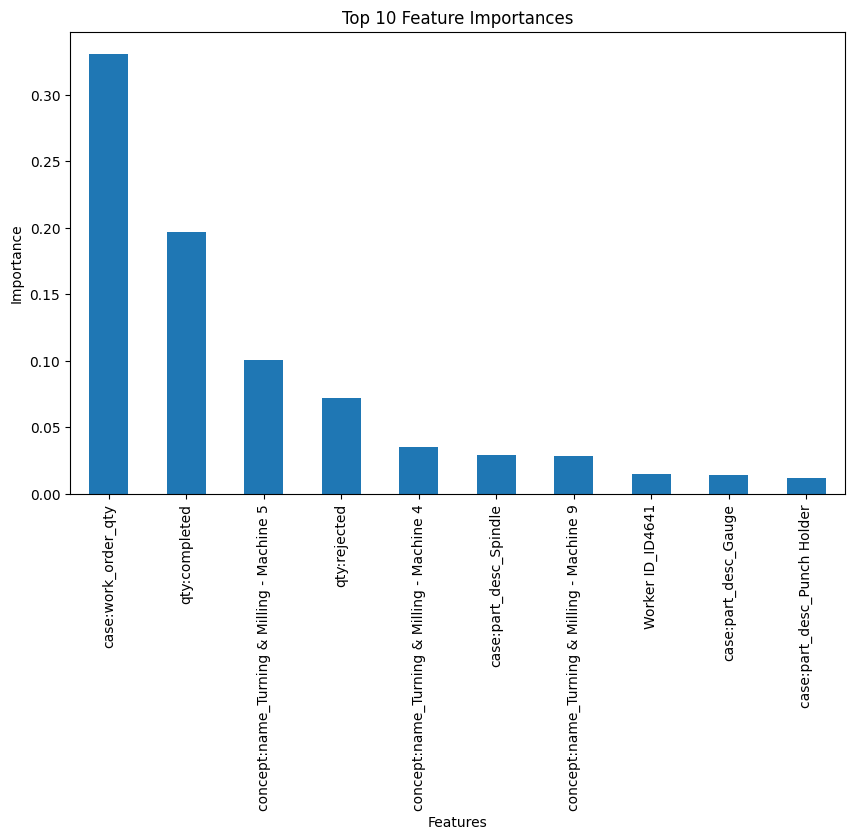

In [14]:
# Train a Random Forest model with a validation split
rf_model_w_val, feature_importances = train_random_forest_with_validation(intra_features, target_column='case_completion_time')

## Inter-case: KDE

### Create inter-case feature

In [15]:
def calculate_running_prefixes(df, start_time_col, end_time_col):
    """
    Calculate the number of overlapping prefixes for each prefix.

    Parameters:
    - df: DataFrame containing prefixes with start and end timestamps.
    - start_time_col: Column name for the prefix start timestamp.
    - end_time_col: Column name for the prefix end timestamp.

    Returns:
    - A pandas Series with the count of overlapping prefixes for each prefix.
    """
    # Initialize a list to store the count of overlaps
    running_prefixes = []

    # Extract start and end times as arrays for efficient comparison
    start_times = df[start_time_col].values
    end_times = df[end_time_col].values

    # Loop over each prefix to calculate overlaps
    for idx in range(len(df)):
        overlaps = (start_times <= end_times[idx]) & (end_times >= start_times[idx])
        running_prefixes.append(overlaps.sum() - 1)  # Exclude the prefix itself

    return pd.Series(running_prefixes, name="running_prefixes", index=df.index)

In [16]:
# Load the encoded prefix features from csv to ensure consistency and timestamp columns
intra_features = pd.read_csv('EncodedPrefixFeatures.csv')
intra_features['running_prefixes'] = calculate_running_prefixes(intra_features, 'time:timestamp', 'complete:timestamp')
intra_features.to_csv("KD1_running_case_features.csv", index=False)

### Training and evaluation

In [17]:
# New name for the feature dataset for clarity
kde_features_combined = intra_features
print(kde_features_combined.columns)

# Drop columns that are not needed
remove_columns = ['case:concept:name', 'Case ID', 'start_time', 'end_time', 'time:timestamp', 'complete:timestamp']
kde_features_combined = kde_features_combined.drop(remove_columns, axis=1)

print("Columns after dropping: ")
print(kde_features_combined.columns)


Index(['Case ID', 'case:concept:name', 'case_completion_time', 'start_time',
       'end_time', 'time:timestamp', 'complete:timestamp', 'is_last_event',
       'qty:completed', 'qty:rejected',
       ...
       'case:part_desc_Slip Ring Adapter', 'case:part_desc_Socket',
       'case:part_desc_Spindle', 'case:part_desc_Spinner',
       'case:part_desc_Spring', 'case:part_desc_Spur Gear',
       'case:part_desc_Tube', 'case:part_desc_Wheel',
       'case:part_desc_Wheel Shaft', 'running_prefixes'],
      dtype='object', length=134)
Columns after dropping: 
Index(['case_completion_time', 'is_last_event', 'qty:completed',
       'qty:rejected', 'qty:for_mrb', 'rework_flag', 'case:work_order_qty',
       'is_last_prefix', 'concept:name_Change Version - Machine 22',
       'concept:name_Final Inspection Q.C.',
       ...
       'case:part_desc_Slip Ring Adapter', 'case:part_desc_Socket',
       'case:part_desc_Spindle', 'case:part_desc_Spinner',
       'case:part_desc_Spring', 'case:part_de

Training the Random Forest model...


Training Progress: 100%|██████████| 100/100 [00:01<00:00, 62.52tree/s]


Validation Root Mean Squared Error (RMSE): 669.8583297087208
Validation R²: 0.9848281628770387
Test Root Mean Squared Error (RMSE): 645.4928940567712
Test R²: 0.9863964979692096
Top 10 Feature Importances:
running_prefixes                              0.244594
case:work_order_qty                           0.240795
qty:completed                                 0.237939
qty:rejected                                  0.054593
concept:name_Turning & Milling - Machine 5    0.044317
concept:name_Turning & Milling - Machine 4    0.023081
Worker ID_ID4932                              0.016099
concept:name_Turning & Milling - Machine 9    0.013997
Report Type_D                                 0.013011
concept:name_Turning - Machine 8              0.008458
dtype: float64


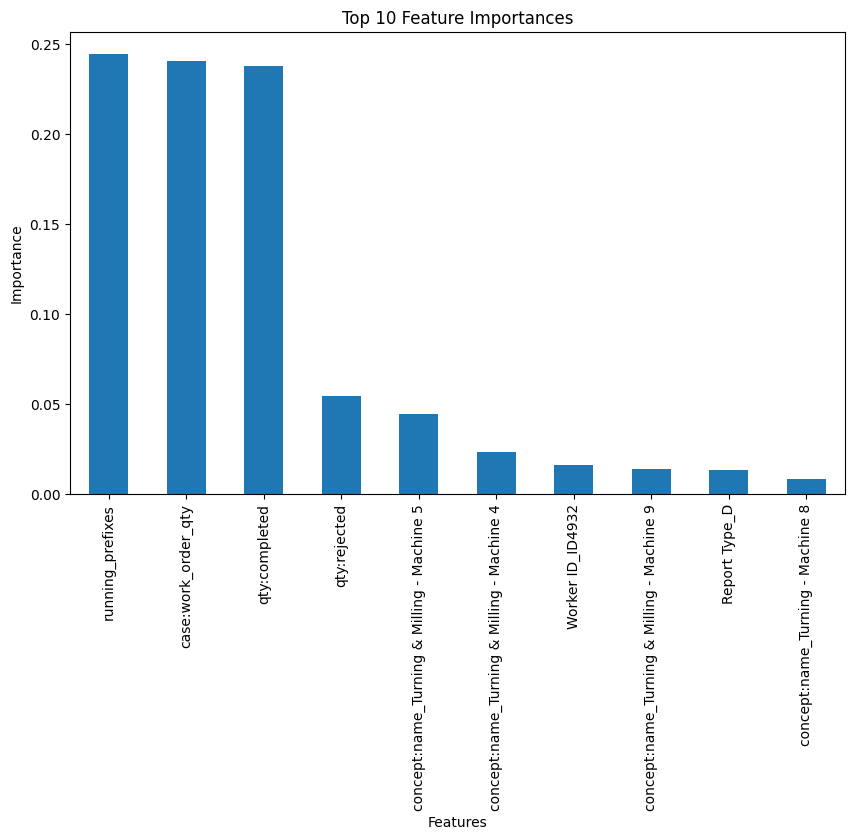

In [18]:
# Train a Random Forest model with a validation split
rf_model_w_val_KD1, feature_importances = train_random_forest_with_validation(kde_features_combined, target_column='case_completion_time')

## Inter-case: DDE

### Create inter-case features

In [19]:
import Levenshtein
import pandas as pd
import numpy as np

def snapshot_distance(case_i, case_j):
    """Calculate snapshot distance: difference between end times in minutes."""
    return abs(case_i['complete:timestamp'] - case_j['complete:timestamp']).total_seconds() / 60

def city_distance(case_i, case_j):
    """Calculate city distance: start-time + end-time differences in minutes."""
    return (
        abs(case_i['complete:timestamp'] - case_j['complete:timestamp']).total_seconds() +
        abs(case_i['time:timestamp'] - case_j['time:timestamp']).total_seconds()
    ) / 60

def control_flow_distance(case_i, case_j):
    """Calculate control-flow edit distance using sequences of activities."""
    return Levenshtein.distance(
        ''.join(case_i['concept:name']),
        ''.join(case_j['concept:name'])
    )

def calculate_proximity(log, target_case_id, k=3, distance_metric='snapshot'):
    """Identify the K-nearest cases based on proximity metrics."""
    target_case = log[log['case:concept:name'] == target_case_id]
    distances = []

    for _, case in log.groupby('case:concept:name'):
        if case['case:concept:name'].iloc[0] != target_case_id:
            # Calculate distances
            control_dist = control_flow_distance(target_case, case)
            if distance_metric == 'snapshot':
                temp_dist = snapshot_distance(target_case.iloc[-1], case.iloc[-1])
            elif distance_metric == 'city':
                temp_dist = city_distance(target_case.iloc[-1], case.iloc[-1])
            else:
                raise ValueError("Invalid distance metric")
            
            # Store combined distances
            distances.append((case['case:concept:name'].iloc[0], control_dist, temp_dist))

    # Sort by temporal proximity and select top K cases
    closest_cases = sorted(distances, key=lambda x: x[2])[:k]
    return closest_cases

def derive_features_from_distances(closest_cases):
    """Create inter-case features from distance pairs."""
    features = {}
    for idx, (_, control_dist, temp_dist) in enumerate(closest_cases):
        features[f'control_dist_k{idx+1}'] = control_dist
        features[f'temp_dist_k{idx+1}'] = temp_dist
    return features

def run_proximity_calculations(log, k=3, distance_metric='snapshot'):
    """Run the proximity calculations and derive inter-case features."""
    dde_features = []

    for case_id in log['case:concept:name'].unique():
        closest_cases = calculate_proximity(log, case_id, k=k, distance_metric=distance_metric)
        features = derive_features_from_distances(closest_cases)
        features['case_id'] = case_id
        dde_features.append(features)

    return pd.DataFrame(dde_features)

# Run the DDE feature extraction
dde_features_snapshot = run_proximity_calculations(log, k=3, distance_metric='snapshot')
dde_features_city = run_proximity_calculations(log, k=3, distance_metric='city')

# Print features derived for snapshot and city distances
print("Snapshot-based DDE Features:")
print(dde_features_snapshot.head())

print("City-based DDE Features:")
print(dde_features_city.head())


Snapshot-based DDE Features:
   control_dist_k1  temp_dist_k1  control_dist_k2  temp_dist_k2  \
0              223           0.0              200           0.0   
1              403           0.0              368           0.0   
2              188         166.0              281         208.0   
3              213           0.0              208           0.0   
4              513          15.0              606         657.0   

   control_dist_k3  temp_dist_k3   case_id  
0              563           0.0    Case 1  
1              523         913.0   Case 10  
2              165         363.0  Case 100  
3              385          15.0  Case 101  
4              677         738.0  Case 102  
City-based DDE Features:
   control_dist_k1  temp_dist_k1  control_dist_k2  temp_dist_k2  \
0              223           0.0              200           0.0   
1              403           0.0              368           0.0   
2              281         224.0              188         305.0   
3    

In [20]:
# load the encoded prefix features
intra_features_dde = pd.read_csv('EncodedPrefixFeatures.csv')
print(intra_features.columns)

# Combine intra-case features, snapshot-based DDE, and city-based DDE
# Assuming intra_features is your intra-case feature DataFrame
combined_features_dde_city= pd.concat([intra_features_dde, dde_features_city], axis=1)

# Drop redundant 'case_id' columns from individual feature sets
combined_features_dde_city = combined_features_dde_city.loc[:, ~combined_features_dde_city.columns.duplicated()]

# Drop columns that are not needed
remove_columns = ['case_id', 'case:concept:name', 'Case ID', 'start_time', 'end_time', 'time:timestamp', 'complete:timestamp']
combined_features_dde_city = combined_features_dde_city.drop(remove_columns, axis=1)


print("Columns after dropping: ")
print(combined_features_dde_city.columns)


# Print the combined features
print("Combined Features:")
print(combined_features_dde_city.columns)
print(combined_features_dde_city.head())

Index(['Case ID', 'case:concept:name', 'case_completion_time', 'start_time',
       'end_time', 'time:timestamp', 'complete:timestamp', 'is_last_event',
       'qty:completed', 'qty:rejected',
       ...
       'case:part_desc_Slip Ring Adapter', 'case:part_desc_Socket',
       'case:part_desc_Spindle', 'case:part_desc_Spinner',
       'case:part_desc_Spring', 'case:part_desc_Spur Gear',
       'case:part_desc_Tube', 'case:part_desc_Wheel',
       'case:part_desc_Wheel Shaft', 'running_prefixes'],
      dtype='object', length=134)
Columns after dropping: 
Index(['case_completion_time', 'is_last_event', 'qty:completed',
       'qty:rejected', 'qty:for_mrb', 'rework_flag', 'case:work_order_qty',
       'is_last_prefix', 'concept:name_Change Version - Machine 22',
       'concept:name_Final Inspection Q.C.',
       ...
       'case:part_desc_Spur Gear', 'case:part_desc_Tube',
       'case:part_desc_Wheel', 'case:part_desc_Wheel Shaft', 'control_dist_k1',
       'temp_dist_k1', 'control_di

Training the Random Forest model...


Training Progress: 100%|██████████| 100/100 [00:00<00:00, 354.51tree/s]


Validation Root Mean Squared Error (RMSE): 335.7169309353739
Validation R²: 0.9919862645095997
Test Root Mean Squared Error (RMSE): 363.3209995337763
Test R²: 0.9890768545636908
Top 10 Feature Importances:
concept:name_Turning & Milling - Machine 6    0.460873
case:work_order_qty                           0.432102
qty:completed                                 0.084985
case:part_desc_Spur Gear                      0.005075
concept:name_Turning & Milling - Machine 9    0.003466
qty:rejected                                  0.001851
Worker ID_ID4132                              0.001499
control_dist_k2                               0.001470
control_dist_k1                               0.001419
control_dist_k3                               0.001291
dtype: float64


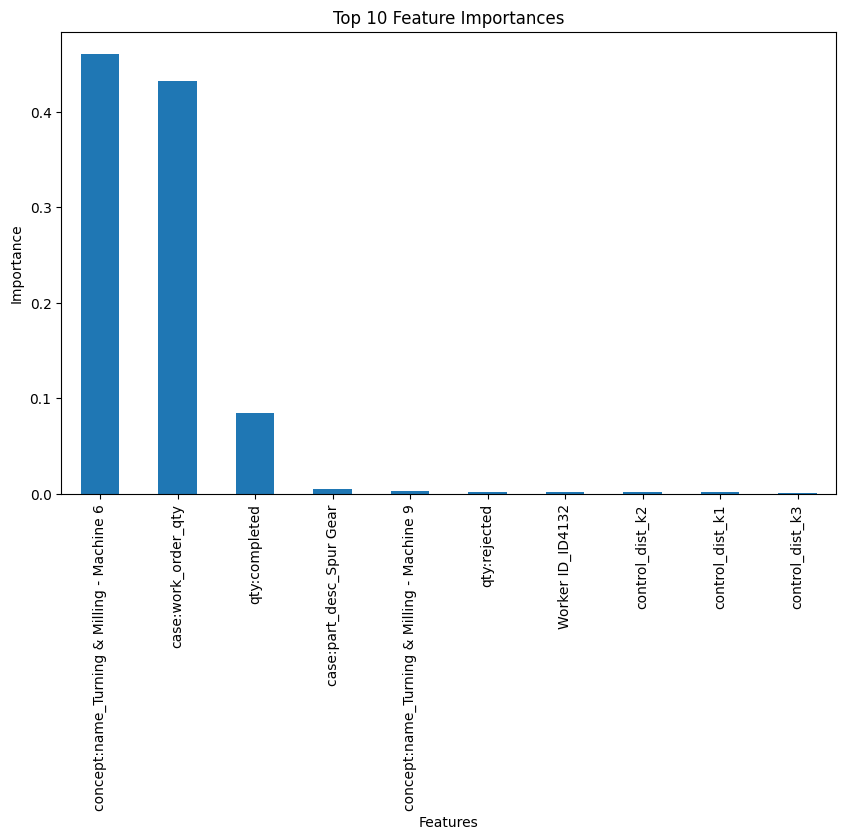

In [21]:
# Train a Random Forest model with a validation split
rf_model_w_val_DDE, feature_importances = train_random_forest_with_validation(combined_features_dde_city, target_column='case_completion_time')